In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
FILE = 'travistorrent_11_1_2017.csv'

In [3]:
dataset = pd.read_csv(FILE, sep=',', engine='c',usecols=['gh_team_size',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'gh_is_pr',
                                                         'gh_pr_created_at',
                                                         'gh_lang',
                                                         'git_branch',
                                                         'gh_num_commits_in_push',
                                                         'git_prev_commit_resolution_status',
                                                         'tr_prev_build',
                                                         'gh_first_commit_created_at',
                                                         'gh_team_size',         
                                                         'gh_pushed_at',
                                                         'gh_build_started_at',
                                                         'tr_log_num_tests_ok',        
                                                         'tr_log_num_tests_failed' ,   
                                                         'tr_log_num_tests_skipped'],dtype={ 'tr_build_id': np.float32,
                                                                                            'gh_project_name': 'category',
                                                                                            'gh_is_pr': np.bool,
                                                                                            'gh_pr_created_at': 'category',
                                                                                            'gh_lang': 'category',
                                                                                            'git_branch': 'category',
                                                                                            'gh_num_commits_in_push': np.float32,
                                                                                            'git_prev_commit_resolution_status': 'category',
                                                                                            'tr_prev_build': np.float32,
                                                                                            'gh_first_commit_created_at': 'category',
                                                                                            'gh_team_size': np.int32,
                                                                                            'gh_pushed_at': 'category',
                                                                                            'gh_build_started_at': 'category',
                                                                                            'tr_log_num_tests_ok': np.float32,
                                                                                            'tr_log_num_tests_failed': np.float32,
                                                                                            'tr_log_num_tests_skipped': np.float32}, encoding='utf-8')


In [1]:
#df_ruby = dataset.dropna() # Remove as linhas NAN
#df_ruby['date'], df_ruby['hours'] = df_ruby.gh_pushed_at.str.split(' ').str # Separa a coluna que possui data e hora em duas novas colunas de data hora

<font size = 4/>
* Filtro de Linguagem

In [14]:
def language_filter(language):
    projects = dataset.drop_duplicates(['gh_project_name']) #Remove nomes duplicados 
    projects = projects.loc[projects['gh_lang'] == language] #Filtra apenas linguagem X
    projects = projects.gh_project_name #Cria uma Serie com nomes unicos dos projetos
    
    return(projects)

<font size = 4/>
* Quantidade de commit por projeto

In [10]:
def commit_flow(projects):
    list_project_name = []
    list_rate_commit = []
    
    for project_name in projects:
        
        # Define projeto
        df_ruby = dataset.loc[dataset['gh_project_name'] == project_name] # Filtro penas o projeto
        
        # Remove linhas duplicadas
        df_ruby = df_ruby.drop_duplicates(['tr_build_id']) # remove as linhas duplicadas
        start_build = df_ruby['tr_build_id'] # cria uma serie com os ids das builds unicas do projeto
        
        # Soma de todos push
        num_commit = df_ruby.gh_num_commits_in_push.sum() 
        
        list_rate_commit.append(num_commit)
        list_project_name.append(project_name)
        
    return(list_rate_commit, list_project_name)

In [31]:
def project_frequency_test(list_rate_commit, list_project_name):
    
    #
    df = pd.DataFrame(list_rate_commit)
    df = df.describe()
    
    # lista de frequencias
    low_frequency = []
    medium_frequency = []
    high_frequency = []
    veryHigh_frequency = []
    
    for i in range(len(list_rate_commit)):
        if(list_rate_commit[i] <= df[0][4]): #Ate o Primeiro quartil
            low_frequency.append(list_project_name[i])
            
        elif(list_rate_commit[i] <= df[0][5]): #Ate a Mediana
            medium_frequency.append(list_project_name[i])
            
        elif(list_rate_commit[i] <= df[0][6]): #Ate o terceiro quartil
            high_frequency.append(list_project_name[i])
        
        else: #Acima do terceiro quartil
            veryHigh_frequency.append(list_project_name[i])
            
    return(low_frequency, medium_frequency, high_frequency, veryHigh_frequency)

In [32]:
language_name = ['java', 'ruby', 'javascript'] 

commit_project = []
project_name = []

for language in language_name:
    project = language_filter(language)
    list_commit, list_project = rate_commit_test(project)
    
    commit_project.append(list_commit)
    
    project_name.append(list_project)


In [33]:
#for i in range(len(commit_project)):
low, medium, high, veryHigh = project_frequency_test(commit_project[1], project_name[1])

In [36]:
medium

['ruby-amqp/amqp',
 'thoughtbot/factory_girl',
 'ledermann/unread',
 'nov/fb_graph',
 'guard/guard-livereload',
 'sstephenson/execjs',
 'mailboxer/mailboxer',
 'thoughtbot/high_voltage',
 'hacketyhack/hackety-hack.com',
 'premailer/premailer',
 'lwe/simple_enum',
 'htty/htty',
 'davetron5000/methadone',
 'RolifyCommunity/rolify',
 'elcuervo/airplay',
 'wvanbergen/chunky_png',
 'rtomayko/tilt',
 'nov/json-jwt',
 'langalex/couch_potato',
 'ariejan/imdb',
 'jruby/jruby-rack',
 'SchemaPlus/schema_plus',
 'lukaszkorecki/CoffeeTags',
 'excon/excon',
 'michelson/lazy_high_charts',
 'typus/typus',
 'walle/gimli',
 'mkdynamic/omniauth-facebook',
 'mongoid/origin',
 'railsware/js-routes',
 'troessner/transitions',
 'lardawge/carrierwave_backgrounder',
 'teampoltergeist/poltergeist',
 'josevalim/rails-footnotes',
 'sferik/mtgox',
 'jnicklas/turnip',
 'dradis/dradisframework',
 'metaskills/less-rails-bootstrap',
 'zinenko/vk-ruby',
 'morgoth/picasa',
 'seejohnrun/ice_cube',
 'spree-contrib/spree_a

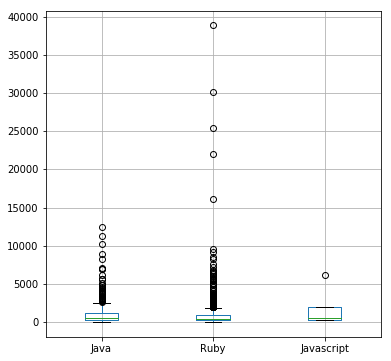

In [16]:
df = pd.DataFrame([('Java', commit_project[0]),
                   ('Ruby', commit_project[1]),
                   ('Javascript', commit_project[2])], columns=['Language', 'commit']).set_index('Language')

df['commit'].apply(lambda x: pd.Series(x)).T.boxplot(figsize=(6,6),rot=0)


In [26]:
df = pd.DataFrame(list_rate_commit)
df = df.describe()


print('quartil 1 ',df[0][4])
print('quartil 2 ',df[0][5])
print('quartil 3 ',df[0][6]) 

quartil 1  231.0
quartil 2  419.5
quartil 3  895.75
